# Setup

In [ ]:
# !pip install scikit-learn
# !pip install numpy
# !pip install scipy
# !pip install sysidentpy
# !pip install matplotlib==3.1.3
# !pip install catboost

https://sysidentpy.org/

This notebook will attempt to predict how a single cell with change from water to land or from land to water, based on a current vector and the state of its neighbors

responses to predict:

cell state  ---  inputs: neighbor cell states (TBD), current magnitude, current direction

# NARX with exogenous inputs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.basis_function import Polynomial, Fourier
from sysidentpy.metrics import root_relative_squared_error
from sysidentpy.utils.generate_data import get_siso_data,get_miso_data
from sysidentpy.utils.display_results import results
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
from sysidentpy.residues.residues_correlation import compute_residues_autocorrelation, compute_cross_correlation

from sklearn.model_selection import TimeSeriesSplit
from catboost import CatBoostRegressor

In [4]:
# load csv with pandas
pixel_mask = pd.read_csv('../toy_island/100_pixel_masks.csv')

currents = pd.read_csv('../toy_island/100_current_vectors.csv')

#remove last column from currents
currents_2d = np.array(currents.iloc[:,0:currents.shape[1]-1])

#get vector length of each row in currents
currents_lengths = np.linalg.norm(currents_2d, axis=1)
#turn 1d array into 2d array
currents_lengths = currents_lengths[:, np.newaxis]

In [8]:
#reshape pixel mask from 100x100 to 100x10x10.  D1 is time, D2 is x, D3 is y.
pixel_mask_3d = np.reshape(pixel_mask.values, (100,10,10))

pixel_mask_3d.shape

(100, 10, 10)

Set up the training and testing data

In [9]:
#setup up variables for training
X = np.array(currents_lengths)[:99]#input is first 99 rows
y = np.array(currents_lengths)[1:]#output is last 99 rows so predicting 1 step ahead

#split data into training and validation sets
from sklearn.model_selection import train_test_split
x_train, x_valid,y_train, y_valid = train_test_split(X, y, train_size=80, test_size=18, shuffle=False, random_state=None)

In [10]:
from sysidentpy.general_estimators import NARX
from sysidentpy.metrics import mean_squared_error
basis_function = Fourier(degree=1)

catboost_narx = NARX(
    base_estimator=CatBoostRegressor(
        iterations=300,
        learning_rate=0.1,
        depth=8
        ),
    xlag=4,
    ylag=4,
    basis_function=basis_function,
    model_type="NARMAX",
    fit_params={'verbose': False}
)

MSE:  0.0002017975722824901


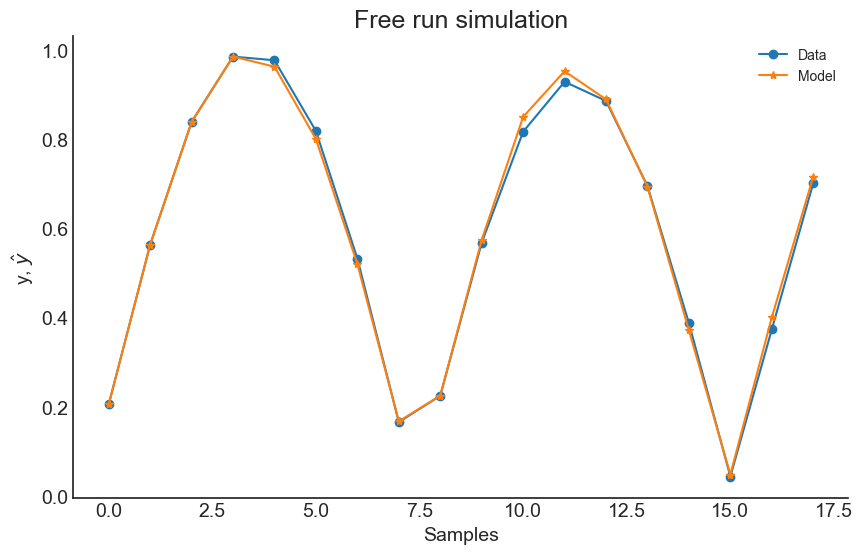

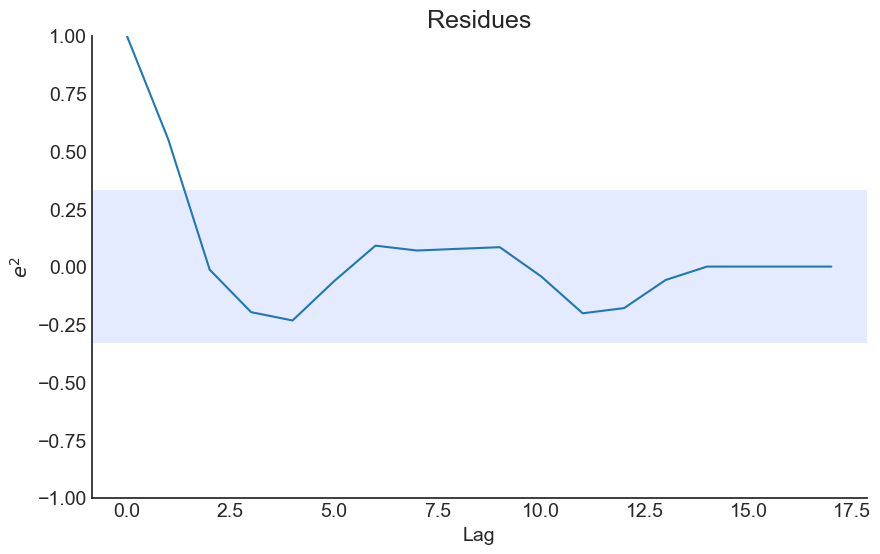

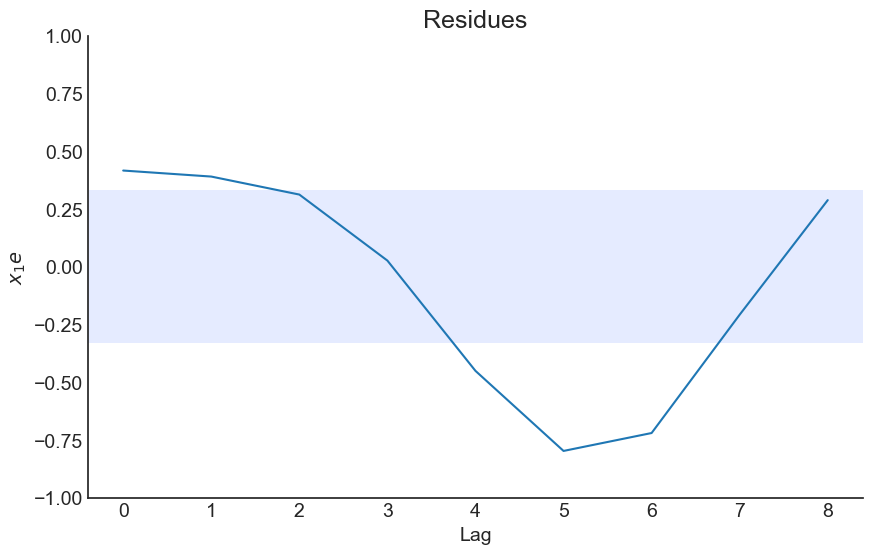

In [11]:
catboost_narx.fit(X=x_train, y=y_train)
yhat = catboost_narx.predict(X=x_valid, y=y_valid, steps_ahead=1)
print("MSE: ", mean_squared_error(y_valid, yhat))
plot_results(y=y_valid, yhat=yhat, n=200)
ee = compute_residues_autocorrelation(y_valid, yhat)
plot_residues_correlation(data=ee, title="Residues", ylabel="$e^2$")
x1e = compute_cross_correlation(y_valid, yhat, x_valid)
plot_residues_correlation(data=x1e, title="Residues", ylabel="$x_1e$")

In [ ]:
basis_function = Polynomial(degree=2)

model = FROLS(
    order_selection=True,
    n_terms=10,
    extended_least_squares=False,
    ylag=3, xlag=3,
    info_criteria='aic',
    estimator='least_squares',
    basis_function=basis_function
)

In [ ]:
model.fit(X=x_train, y=y_train)

In [ ]:
#predicting 10 time steps ahead
yhat = model.predict(X=x_valid, y=y_valid,steps_ahead=10)
rrse = root_relative_squared_error(y_valid, yhat)
print(rrse)

r = pd.DataFrame(
    results(
        model.final_model, model.theta, model.err,
        model.n_terms, err_precision=8, dtype='sci'
        ),
    columns=['Regressors', 'Parameters', 'ERR'])
print(r)
plot_results(y=y_valid, yhat = yhat, n=1000)
ee = compute_residues_autocorrelation(y_valid, yhat)
# plot_residues_correlation(data=ee, title="Residues", ylabel="$e^2$")
# x1e = compute_cross_correlation(y_valid, yhat, x_valid[:, 0])
# plot_residues_correlation(data=x1e, title="Residues", ylabel="$x_1e$")

In [ ]:
#predicting 1 timestep ahead (much easier for network)
yhat = model.predict(X=x_valid, y=y_valid,steps_ahead=1)
rrse = root_relative_squared_error(y_valid, yhat)
print(rrse)

r = pd.DataFrame(
    results(
        model.final_model, model.theta, model.err,
        model.n_terms, err_precision=8, dtype='sci'
        ),
    columns=['Regressors', 'Parameters', 'ERR'])
print(r)
plot_results(y=y_valid, yhat = yhat, n=1000)
ee = compute_residues_autocorrelation(y_valid, yhat)
# plot_residues_correlation(data=ee, title="Residues", ylabel="$e^2$")
# x1e = compute_cross_correlation(y_valid, yhat, x_valid[:, 0])
# plot_residues_correlation(data=x1e, title="Residues", ylabel="$x_1e$")

In [ ]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from sysidentpy.metrics import mean_squared_error
# from sysidentpy.utils.generate_data import get_siso_data,get_miso_data

# # Generate a dataset of a simulated dynamical system
# x_train, x_valid, y_train, y_valid = get_miso_data(
#     n=1000,
#     colored_noise=False,
#     sigma=0.001,
#     train_percentage=80
# )
# x_train.shape

# basis_function = Polynomial(degree=2)


# from torch import nn
# from sysidentpy.neural_network import NARXNN
# from sysidentpy.basis_function._basis_function import Polynomial
# from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
# from sysidentpy.residues.residues_correlation import compute_residues_autocorrelation, compute_cross_correlation


# class NARX(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.lin = nn.Linear(4, 10)
#         self.lin2 = nn.Linear(10, 10)
#         self.lin3 = nn.Linear(10, 1)
#         self.tanh = nn.Tanh()

#     def forward(self, xb):
#         z = self.lin(xb)
#         z = self.tanh(z)
#         z = self.lin2(z)
#         z = self.tanh(z)
#         z = self.lin3(z)
#         return z

# basis_function=Polynomial(degree=1)

# narx_net = NARXNN(
#     net=NARX(),
#     ylag=2,
#     xlag=[[1],[1]],
#     basis_function=basis_function,
#     model_type="NARMAX",
#     loss_func='mse_loss',
#     optimizer='Adam',
#     epochs=200,
#     verbose=False,
#     optim_params={'betas': (0.9, 0.999), 'eps': 1e-05} # optional parameters of the optimizer
# )

# narx_net.fit(X=x_train, y=y_train)
# yhat = narx_net.predict(X=x_valid, y=y_valid)
# plot_results(y=y_valid, yhat=yhat, n=200)
